# Active Learning using Detectron2 on Comma10k dataset

In [ ]:
!pip install lightly

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

     |████████████████████████████████| 275 kB 4.0 MB/s 
     |████████████████████████████████| 145 kB 65.4 MB/s 
     |████████████████████████████████| 524 kB 58.1 MB/s 
     |████████████████████████████████| 112 kB 71.3 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 40.6 MB/s 
     |████████████████████████████████| 829 kB 41.8 MB/s 
     |████████████████████████████████| 132 kB 60.6 MB/s 
     |████████████████████████████████| 332 kB 63.7 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 192 kB 68.0 MB/s 
     |████████████████████████████████| 160 kB 67.5 MB/s 
     |████████████████████████████████| 271 kB 72.1 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=11cc6dbcdb0a6fdb92ce97298fa2133aca322bd28451b96405fccdd8ef0ae4f0
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 729 kB/s 
     |████████████████████████████████| 130 kB 5.8 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 749 kB 19.1 MB/s 
     |████████████████████████████████| 843 kB 53.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=3662a78af8aee13cdfe8a70d2944a3999add04953b9f216fa61efac9a8db161a
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20


### Download [Comma10k dataset](https://github.com/commaai/comma10k) 

Comma10k dataset has about 10k images of autonomous car driving images

In [ ]:
%%time
!git clone https://github.com/commaai/comma10k

Cloning into 'comma10k'...
remote: Enumerating objects: 66689, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (319/319), done.
remote: Total 66689 (delta 69), reused 264 (delta 20), pack-reused 66350
Receiving objects: 100% (66689/66689), 10.74 GiB | 3.47 MiB/s, done.
Resolving deltas: 100% (8624/8624), done.
Checking out files: 100% (23800/23800), done.
CPU times: user 19.7 s, sys: 3.3 s, total: 23 s
Wall time: 54min 58s


In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-txv8t0kg
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-txv8t0kg
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5703971 sha256=4a6698bedc6efd9f1fcca7f3d4118bf5cf919ea690bcfd580d85362254f9ff80
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbeqeff6/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
Successfully built detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu101
    Uninstalling detectron2-0.6+cu101:
      Successfully uninstalled detectron2-0.6+cu101


In [ ]:
#imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random, glob
from google.colab.patches import cv2_imshow
import tqdm, gc

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import lightly
from lightly.active_learning.utils.bounding_box import BoundingBox
from lightly.active_learning.utils.object_detection_output import ObjectDetectionOutput
from lightly.active_learning.scorers import ScorerObjectDetection
from lightly.api.api_workflow_client import ApiWorkflowClient
from lightly.active_learning.agents import ActiveLearningAgent
from lightly.active_learning.config import SamplerConfig
from lightly.openapi_generated.swagger_client import SamplingMethod

# Uploading the dataset to lightly

In [ ]:
#removed tokens before submission

!lightly-magic token='' dataset_id='' input_dir='/content/comma10k/imgs' trainer.max_epochs=0

########## Starting to embed your dataset.
Compute efficiency: 0.09: 100% 118/118 [00:51<00:00,  2.29it/s]
Embeddings are stored at /content/lightly_outputs/2021-12-06/19-42-25/embeddings.csv
########## Starting to upload your dataset to the Lightly platform.
Uploading images (with 2 workers).
100% 1888/1888 [1:19:48<00:00,  2.54s/imgs]
Finished the upload of the dataset.
Starting upload of embeddings.
Finished upload of embeddings.
########## Finished


In [ ]:
YOUR_TOKEN = ""  #removed token and dataset id before submission for privacy
YOUR_DATASET_ID = ""  

def try_get_token_and_id_from_env():
    token = os.getenv('TOKEN', YOUR_TOKEN)
    dataset_id = os.getenv('AL_TUTORIAL_DATASET_ID', YOUR_DATASET_ID)
    return token, dataset_id

YOUR_TOKEN, YOUR_DATASET_ID = try_get_token_and_id_from_env()

# Inference on unlabeled data

In [ ]:
# create Lightly API client
api_client = ApiWorkflowClient(dataset_id=YOUR_DATASET_ID, token=YOUR_TOKEN)
al_agent = ActiveLearningAgent(api_client)

In [ ]:
# we can access the images of the dataset we want to use for active learning using
# the `al_agent.query_set` property

# let's print the first 3 entries
print(al_agent.query_set[:3])

['0000_0085e9e41513078a_2018-08-19--13-26-08_11_864.png', '0001_a23b0de0bc12dcba_2018-06-24--00-29-19_17_79.png', '0002_e8e95b54ed6116a6_2018-09-05--22-04-33_2_608.png']


### Detectron2 model 

Using this model to predict the new images 

- Using re-trained Faster R-CNN with a ResNet-50 backbone
- Using MS COCO pre-trained model from detectron2

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_280758.pkl: 167MB [00:15, 10.8MB/s]                           


In [ ]:
def predict_and_overlay(model, fname):
  im = cv2.imread(fname)
  out = model(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(out["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
def convert_bbox_detectron2lightly(outputs):
    height, width = outputs['instances'].image_size
    boxes = []

    for (bbox_raw, score, class_idx) in zip(outputs['instances'].pred_boxes.tensor,
                                            outputs['instances'].scores,
                                            outputs['instances'].pred_classes):
        x0, y0, x1, y1 = bbox_raw.cpu().numpy()
        x0 /= width
        y0 /= height
        x1 /= width
        y1 /= height

        boxes.append(BoundingBox(x0, y0, x1, y1))
    output = ObjectDetectionOutput.from_scores(
      boxes, outputs['instances'].scores.cpu().numpy(),
      outputs['instances'].pred_classes.cpu().numpy().tolist())
    return output

### Predictions

In [ ]:
obj_detection_outputs = []
pbar = tqdm.tqdm(al_agent.query_set)
for fname in pbar:
  fname_full = os.path.join('./comma10k/imgs/', fname)
  im = cv2.imread(fname_full)
  out = predictor(im)
  obj_detection_output = convert_bbox_detectron2lightly(out)
  obj_detection_outputs.append(obj_detection_output)

  0%|          | 0/1888 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1888/1888 [02:29<00:00, 12.59it/s]


In [ ]:
scorer = ScorerObjectDetection(obj_detection_outputs)
scores = scorer.calculate_scores()

In [ ]:
max_score = scores['uncertainty_margin'].max()
idx = scores['uncertainty_margin'].argmax()
print(f'Highest uncertainty_margin score found for idx {idx}: {max_score}')

Highest uncertainty_margin score found for idx 1395: 0.9794710874557495


Model Predictions 

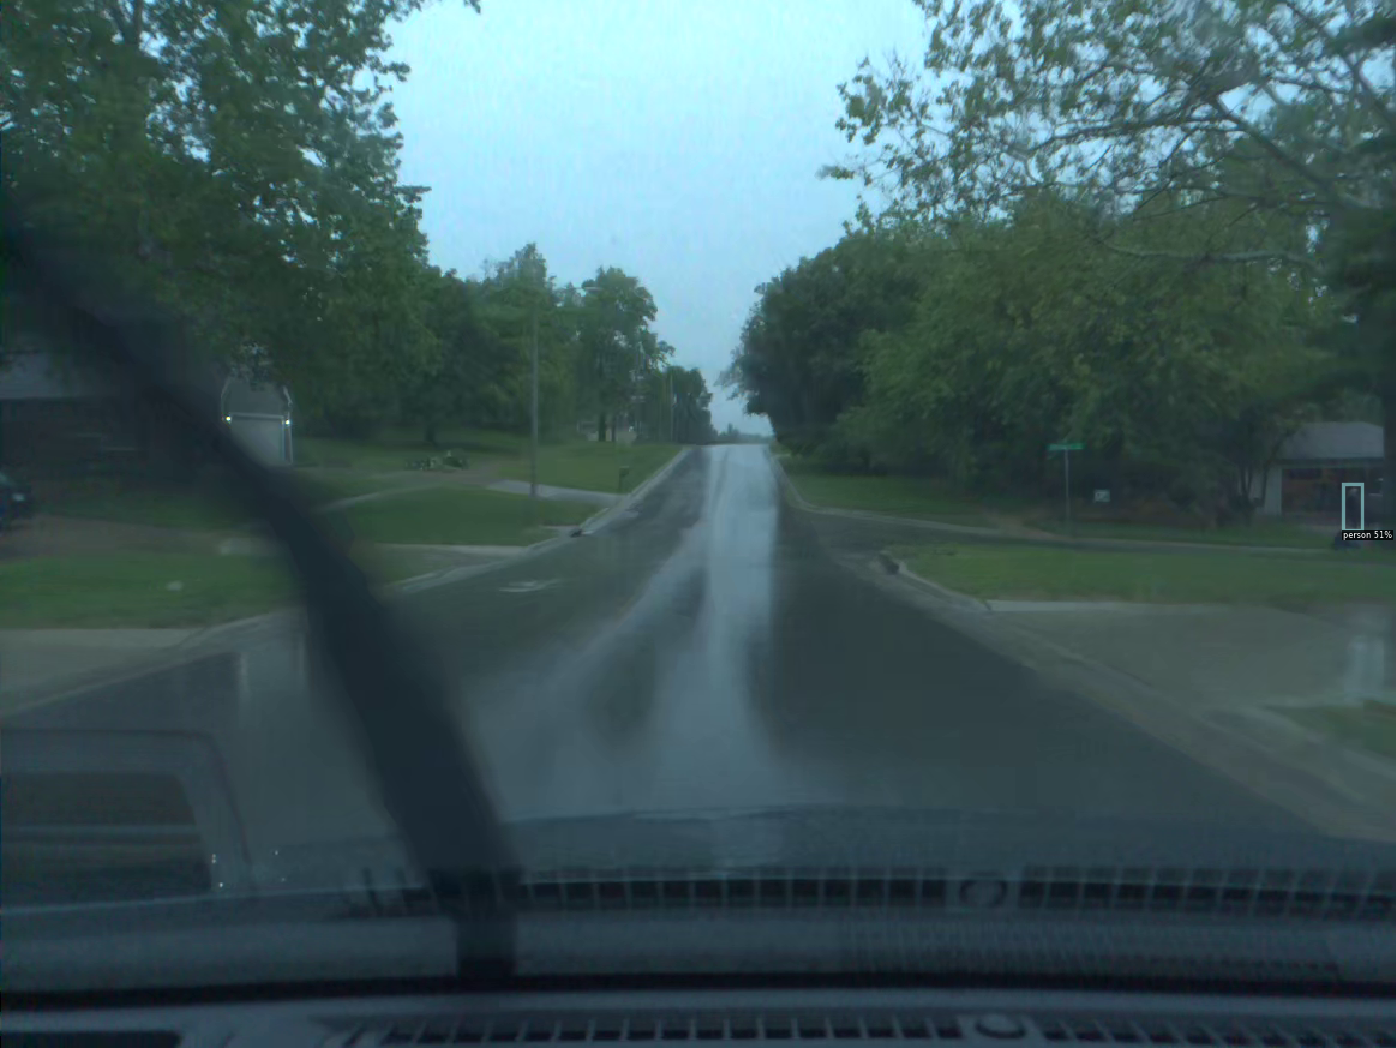

In [ ]:
fname = os.path.join('./comma10k/imgs/', al_agent.query_set[idx])
predict_and_overlay(predictor, fname)

In [ ]:
config = SamplerConfig(
  n_samples=100, 
  method=SamplingMethod.CORAL, 
  name='active-learning-loop-1'
)
al_agent.query(config, scorer)

In [ ]:
print(len(al_agent.added_set))

100


In [ ]:
al_agent.added_set[:5]

['0002_e8e95b54ed6116a6_2018-09-05--22-04-33_2_608.png',
 '0003_97a4ec76e41e8853_2018-09-29--22-46-37_5_585.png',
 '0008_b8727c7398d117f5_2018-10-22--15-38-24_71_990.png',
 '0009_ef53f1ffea65e93c_2018-07-26--03-48-48_14_191.png',
 '0021_1aaddf65aad975af_2018-07-31--07-59-51_1_124.png']

### Model predictions of the first 5 images in the dataset

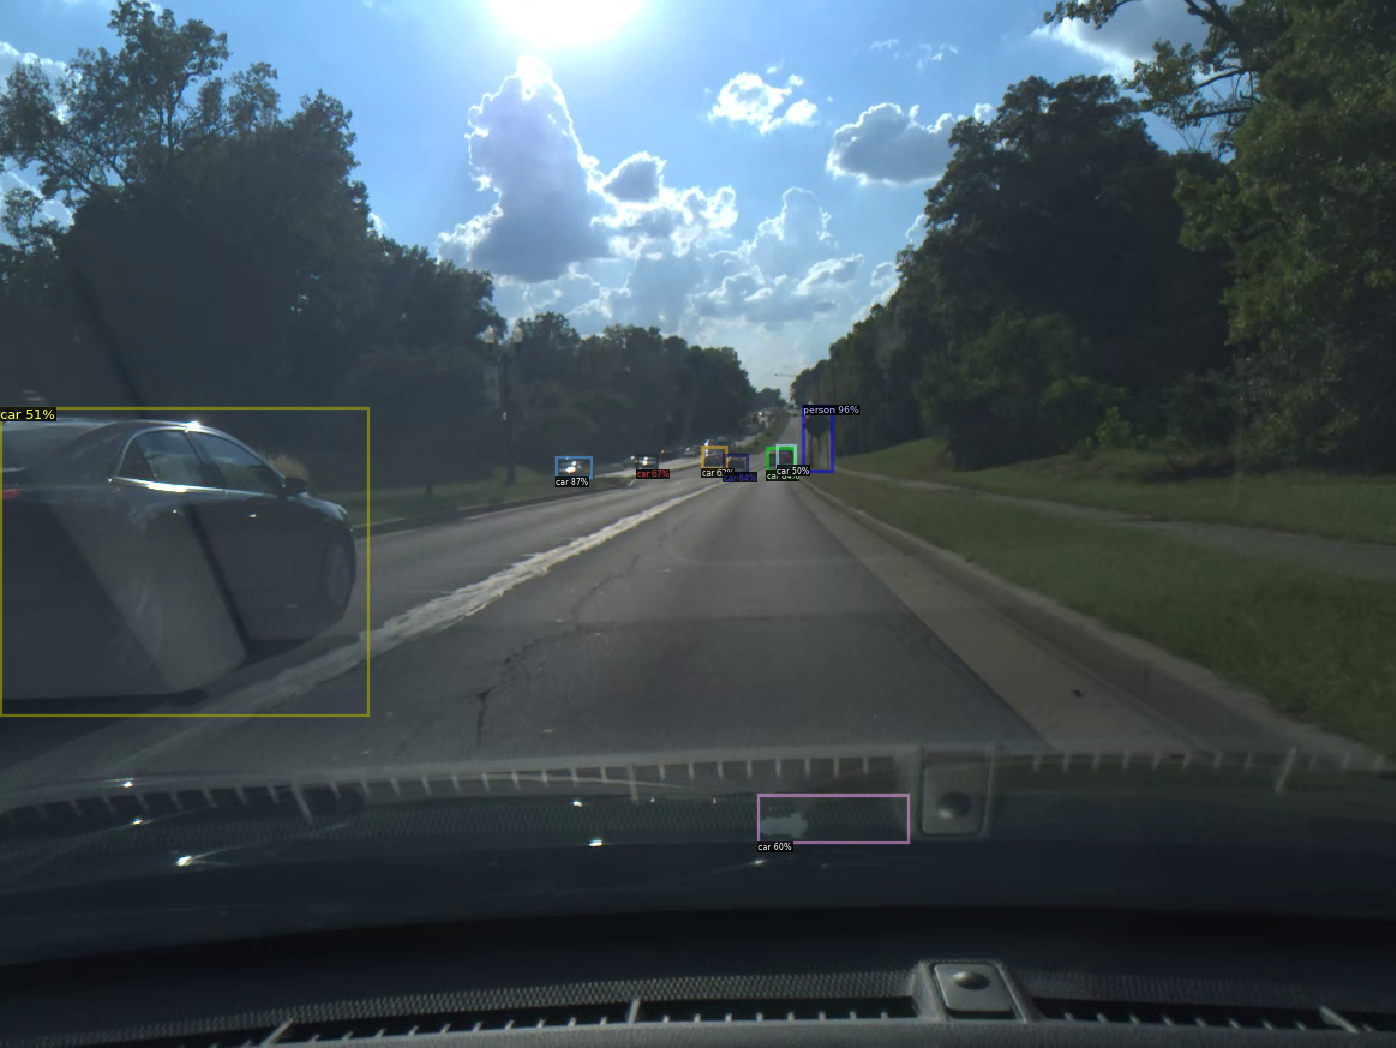

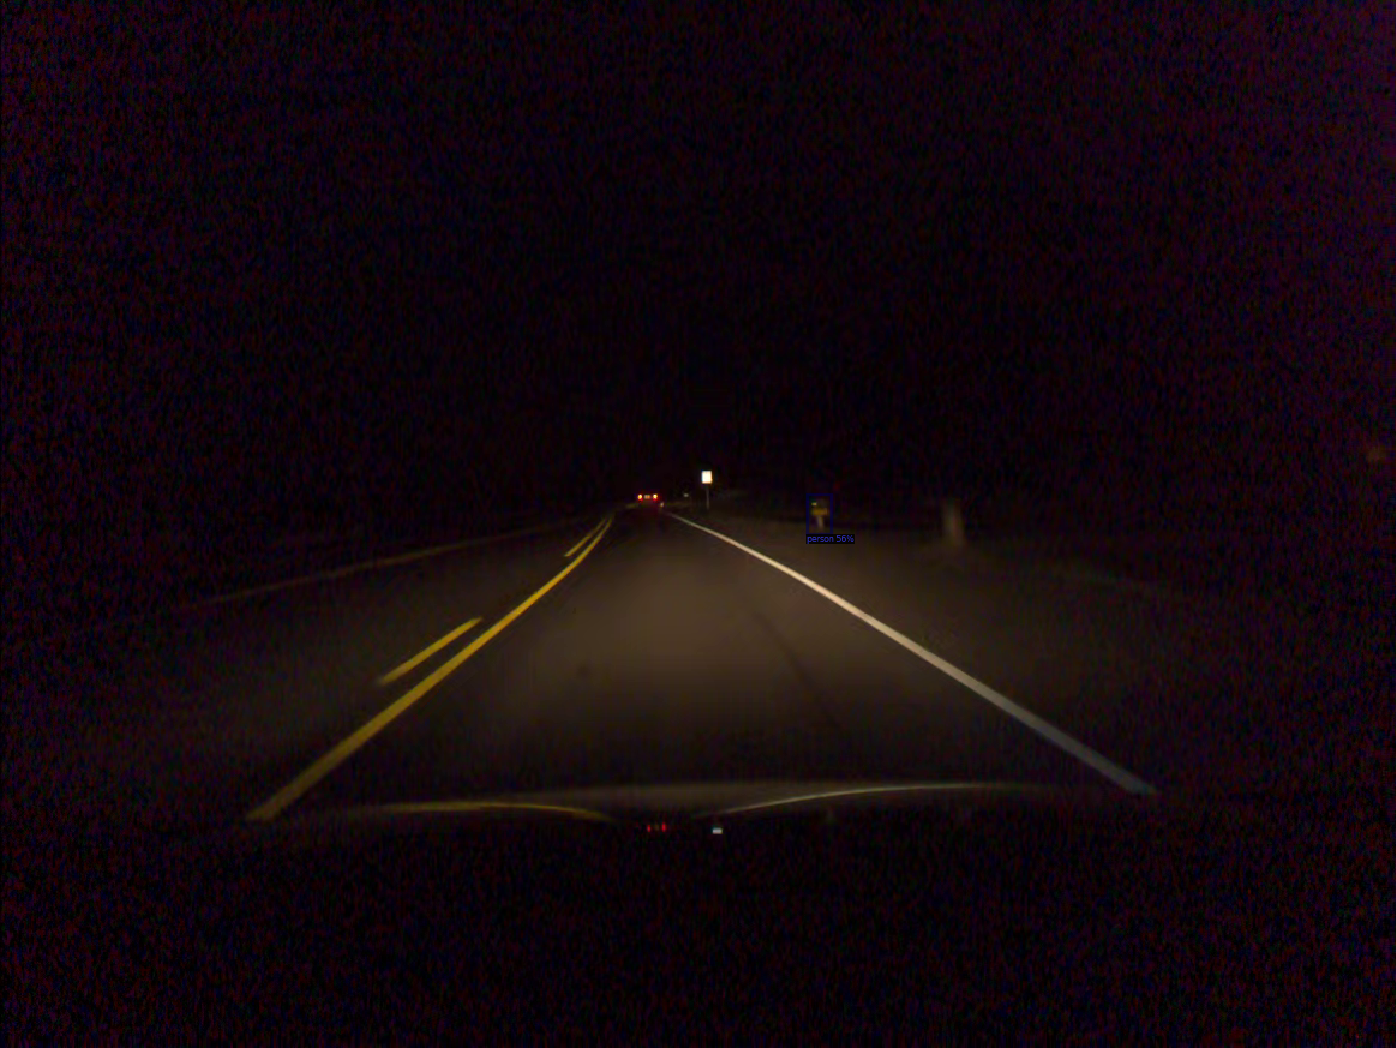

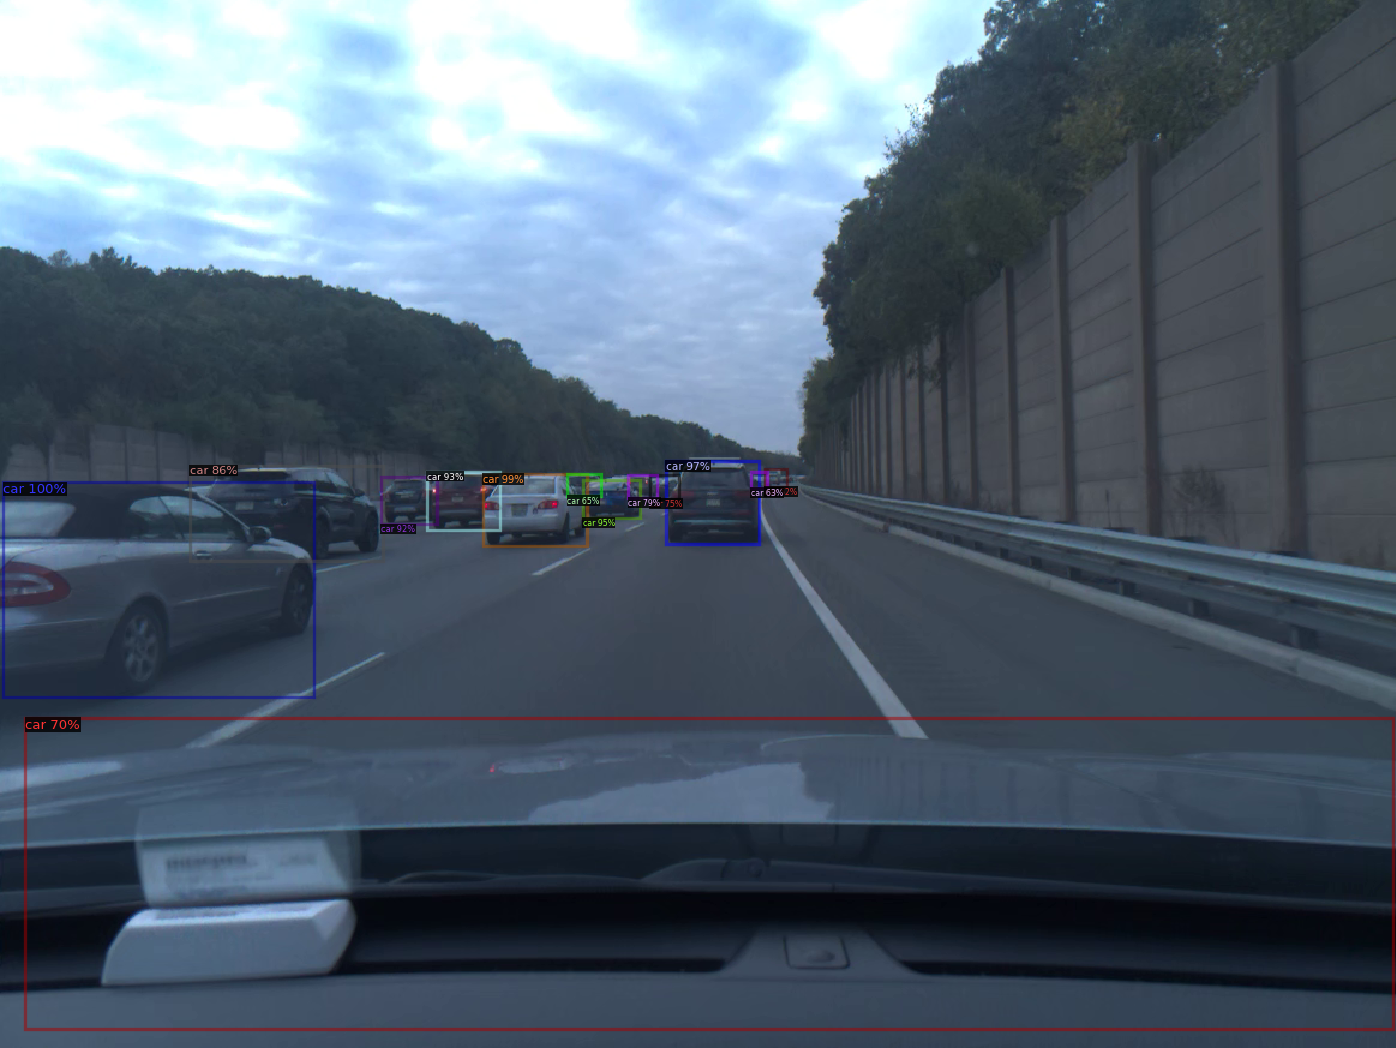

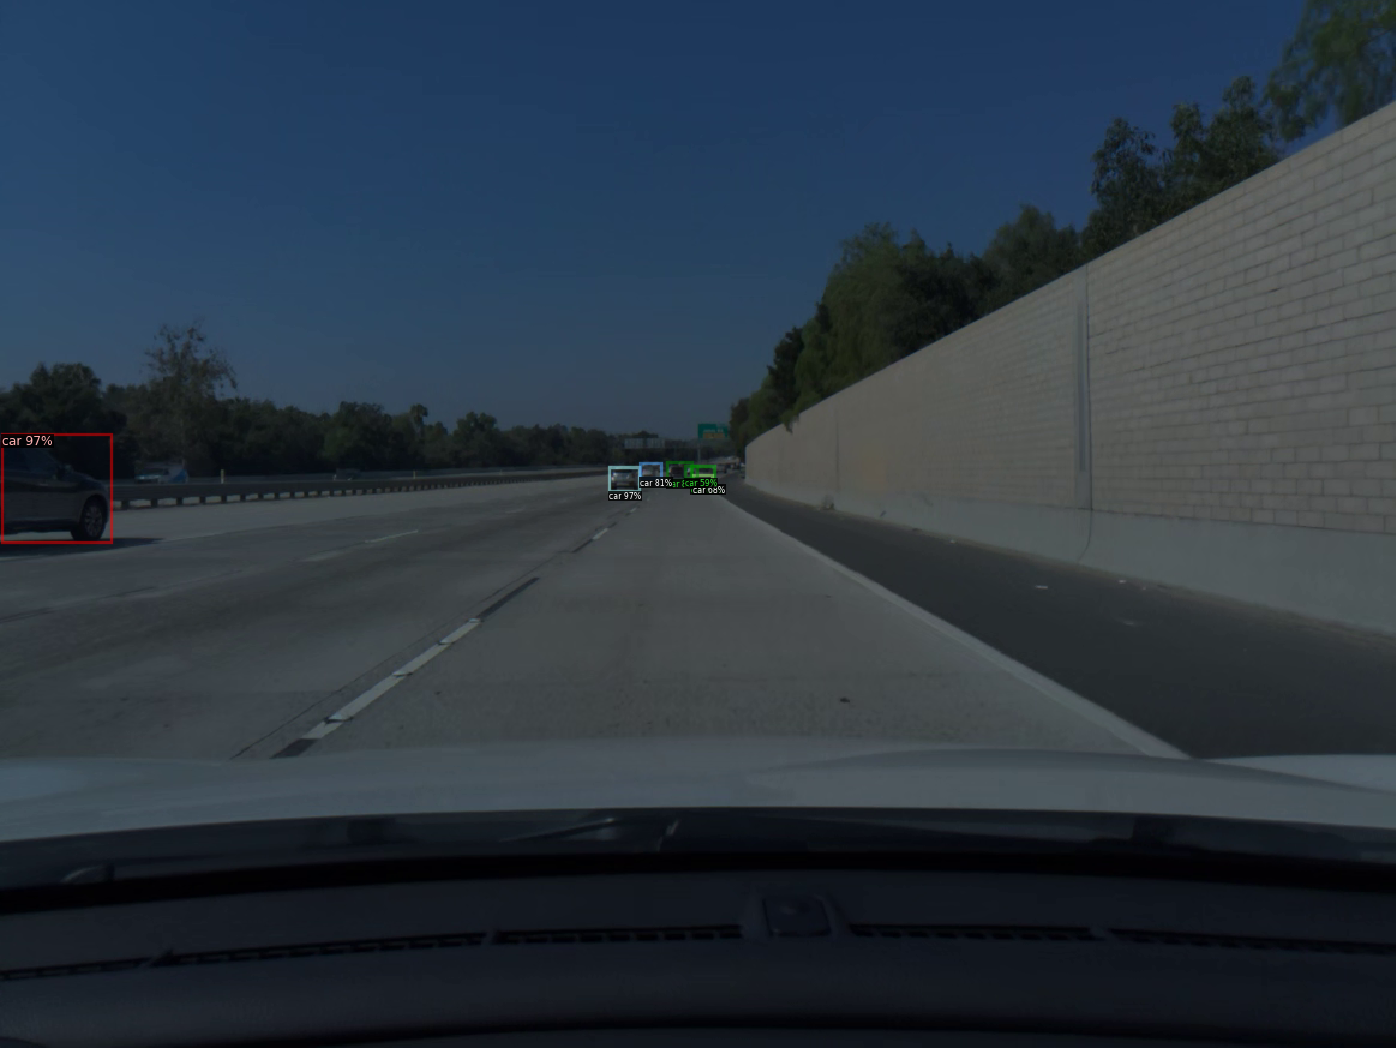

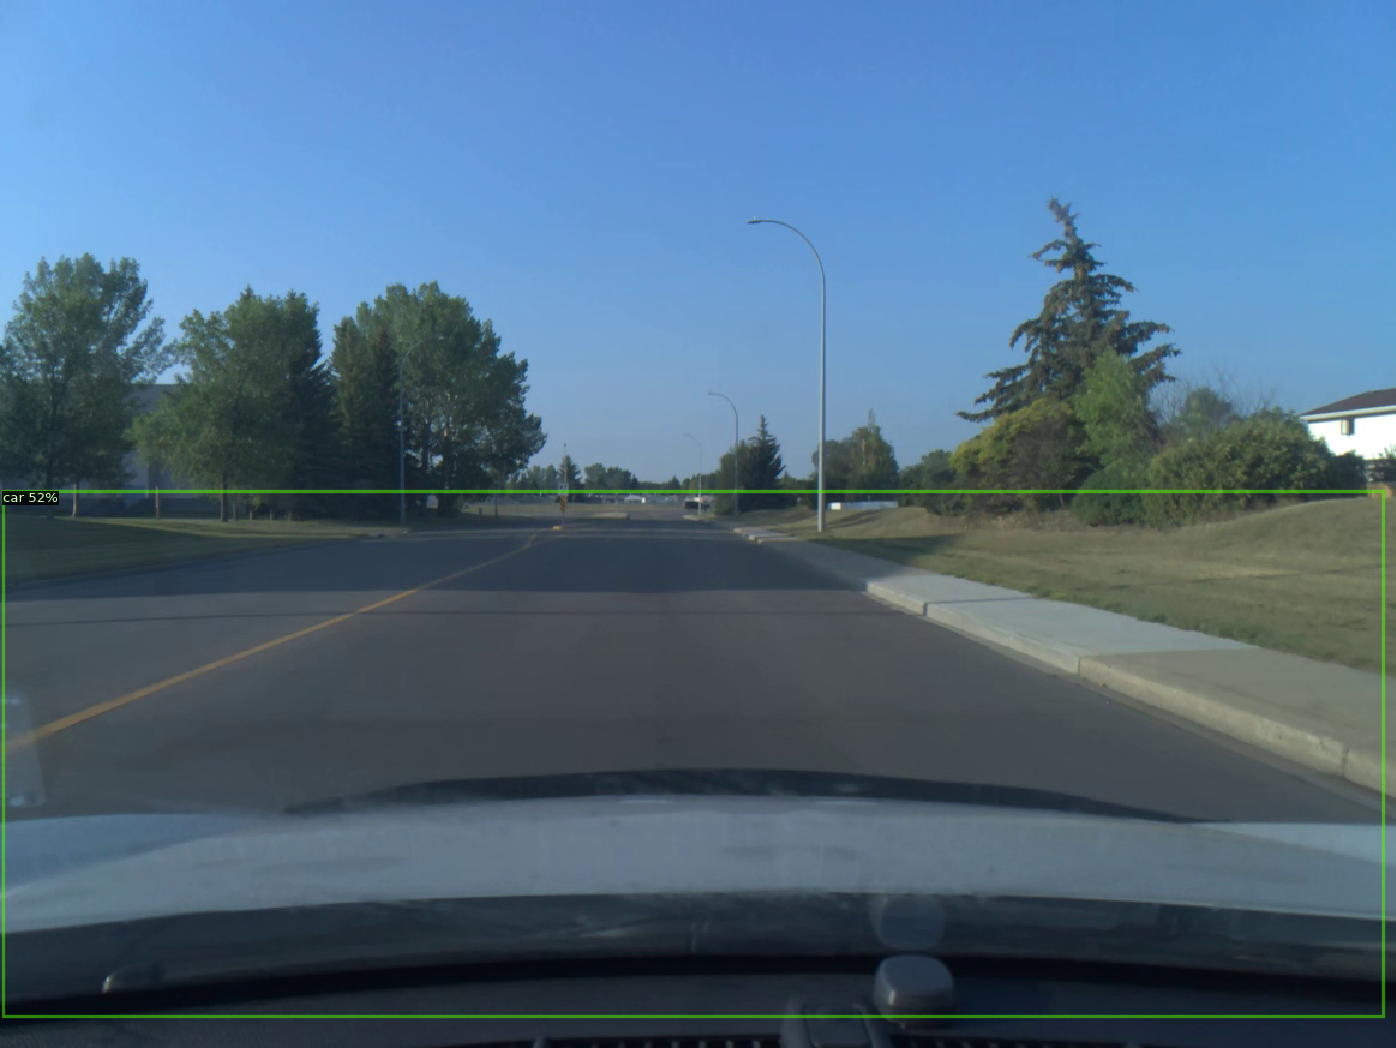

In [ ]:
to_label = [os.path.join('./comma10k/imgs/', x) for x in al_agent.added_set]
for i in range(5):
  predict_and_overlay(predictor, to_label[i])